In [125]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import json
import os
import re

In [127]:
import matplotlib.font_manager as fm

font_files = fm.findSystemFonts(fontpaths=['/mnt/c/Windows/Fonts', '/mnt/c/Users/trommer/AppData/Local/Microsoft/Windows/Fonts'], fontext='otf')

for font_file in font_files:
    fm.fontManager.addfont(font_file)

import matplotlib as mpl
#mpl.rcParams['font.family'] = 'Neue Haas Grotesk Text Pro'
# mpl.rcParams['font.family'] = 'Linux Biolinum'
mpl.rcParams['font.family'] = 'CMU Sans Serif'

plt.rcParams['font.size'] = 8
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.axisbelow'] = True

colors = sns.color_palette('Set2')
sns.set_palette('Set2')

In [128]:
def read_results(path):
    with open(path, 'r') as f:
        data = json.load(f)
    benchmarks = data['benchmarks']

    res = []
    for b in benchmarks:
        flat_dict = {**b['params'], **b['stats']}
        res.append(flat_dict)

    df = pd.DataFrame.from_records(res)
    b_name = os.path.basename(path)
    f_name, _ = os.path.splitext(b_name)
    df['filename'] = f_name
    return df

In [129]:
ta = read_results('benchmark_results/221215_conv_layer_torchapprox.json')
tf = read_results('benchmark_results/221215_conv_layer_tfapprox.json')
df = pd.concat([ta, tf], ignore_index=True)
df.loc[df.bench_type.isna(), 'bench_type'] = 'tfapprox'
df.bench_type = df.bench_type.apply(lambda s: s[0] if isinstance(s, list) else s)
df.sort_values(['channels', 'bench_type'], inplace=True, ignore_index=True)
df = df[~(df.bench_type.str.contains('mul12') | df.bench_type.str.contains('mul16'))]
df = df[df.channels > 1].reset_index(drop=True)

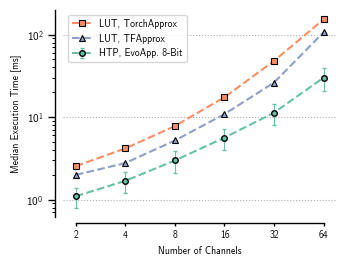

In [130]:
fig = plt.figure(figsize=(3.5,2.7))
ax = fig.add_subplot(111)


# ax.yaxis.set_tick_params(which='minor', size=2, width=0.75)

params = [
    
    ('mul8s', 'HTP, EvoApp. 8-Bit', 'o'),
    ('lut','LUT, TorchApprox', 's'),
    ('tfapprox', 'LUT, TFApprox', '^'),
]
for key, name, marker in params:
    models = df[df.bench_type.str.contains(key)]
    if key == 'mul8s':
        means = models.groupby('channels')['median'].agg('mean')
        stds = models.groupby('channels')['median'].agg('std')
        x = np.unique(models.channels)
        plt.errorbar(x, means.values * 1000, yerr=stds.values * 1000, label=name, capsize = 1.5, linestyle='--', ecolor=colors[0], elinewidth=0.8, markersize=4.0, marker=marker, markeredgecolor='black', barsabove=False, zorder=3)
        # plt.errorbar(x, means.values * 1000, yerr=stds.values * 1000)
    else:
        plt.plot(models.channels, models['median'] * 1000, label=name, marker=marker, linestyle='--', markersize=5.0, markeredgecolor='black', markeredgewidth=0.8)

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel('Number of Channels', fontsize=7)
ax.set_ylabel('Median Execution Time [ms]', fontsize=7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 6))
ax.spines['bottom'].set_position(('outward', 4))
ax.spines['bottom'].set_bounds(2, 64)

ax.set_xticks(np.unique(df.channels))
ax.set_xticklabels(np.unique(df.channels), fontsize=7)
ax.xaxis.set_tick_params(which='major', size=2, width=1)
ax.xaxis.set_tick_params(which='minor', bottom=False)

ax.yaxis.set_tick_params(which='major', size=5, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='out')
ax.yaxis.grid(linestyle='dotted')
#ax.set_ylim(2e-1, 1e3)
# ax.set_xlim(1.4,70)

ax.legend(loc='upper left', fontsize=7)
plt.tight_layout()
plt.savefig('/mnt/c/Users/trommer/Desktop/torchapprox-tcad/figures/plots/conv2d_benchmark.pdf', bbox_inches='tight')
plt.show()
    

In [131]:
from scipy.stats import gmean
vals = df[df.bench_type == 'tfapprox']['median'] / df[df.bench_type.str.contains('mul8')].groupby('channels')['median'].agg('mean').values
vals

17     1.814306
35     1.644143
53     1.746924
71     1.926632
89     2.316555
107    3.552253
Name: median, dtype: float64

In [132]:
pretty_names = {
    'alexnet' : 'AlexNet',
    'effcientnet_b0' : 'EfficientNetB0',
    'mobilenet_v2' : 'MobileNetV2',
    'resnet18' : 'ResNet18',
    'resnet50' : 'ResNet50',
    'vgg16' : 'VGG16',
}
df = read_results('benchmark_results/221205_networks.json')
df.loc[df.bench_type.isna(), 'bench_type'] = 'adaPT'
df.bench_type = df.bench_type.apply(lambda s: s[0] if isinstance(s, list) else s)
df = df.loc[~df.bench_type.str.contains("accurate")]
df.bench_architecture = df.bench_architecture.map(pretty_names)
df.sort_values(['bench_architecture', 'bench_type'], inplace=True, ignore_index=True)

In [133]:
print(gmean(df[df.bench_type == 'adaPT']['median'] / df[df.bench_type.str.contains('lut')].groupby('bench_architecture')['median'].agg('mean').values))
print(gmean(df[df.bench_type == 'adaPT']['median'] / df[df.bench_type.str.contains('mul8s')].groupby('bench_architecture')['median'].agg('mean').values))
print(gmean(df[df.bench_type == 'lut']['median'] / df[df.bench_type.str.contains('mul8s')].groupby('bench_architecture')['median'].agg('mean').values))
print((df[df.bench_type == 'lut']['median'] / df[df.bench_type.str.contains('baseline')].groupby('bench_architecture')['median'].agg('mean').values))

35.699849129724136
96.42065462102792
2.7008700868919604
2       9.720705
41      1.932220
80      2.000238
119     7.303726
158     5.498940
197    16.663679
Name: median, dtype: float64


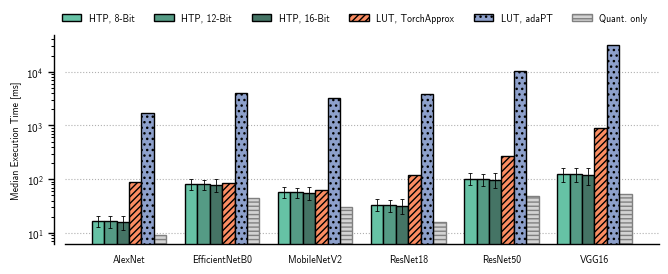

In [134]:
params = [
    # ('mul8s_1L2D', 'HTP Model 1L2D', '///'),
    ('mul8s', 'HTP, 8-Bit', '\\\\\\\\', 0),
    ('mul12s', 'HTP, 12-Bit', '////', 1),
    ('mul16s', 'HTP, 16-Bit', 'xxxx', 2),
    ('lut', 'LUT, TorchApprox', '/////', 1),
    ('adaPT', 'LUT, adaPT', '...', 2),
    ('baseline', 'Quant. only', None, 3),
]

width = 0.8/len(params)

fig = plt.figure(figsize=(7.1,2.8))
ax = fig.add_subplot(111)
colors = sns.color_palette('Set2')

for i, (key, label, hatch, c_idx) in enumerate(params):
    ans = df[df.bench_type.str.contains(key)]
    x = np.arange(len(np.unique(ans.bench_architecture))) + i*width
    if key == 'baseline':
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='grey', hatch='----', color = 'lightgrey', label=label, zorder=1)
    elif 'mul' in key:
        palette = sns.dark_palette(colors[0], 5, reverse=True)
        means = ans.groupby('bench_architecture')['median'].agg('mean')
        stds = ans.groupby('bench_architecture')['median'].agg('std')
        ax.bar(x, height=means.values * 1000, yerr=stds.values * 1000, capsize=1.2, error_kw = {'lw':0.6, 'mew': 0.6}, width=width, align='edge', edgecolor='black', color = palette[c_idx], label=label, zorder=2)
    else:
        ax.bar(x, height=ans['median'].values * 1000, width=width, align='edge', edgecolor='black', color = colors[c_idx], hatch=hatch, label=label, zorder=2)

labels = np.unique(df.bench_architecture)
ax.xaxis.set_ticks(np.arange(len(labels)) + len(params)/2 * width, labels, size=7)
ax.xaxis.set_tick_params(bottom=False)
# ax.set_xlim(-0.4, len(np.unique(df.bench_architecture))+0.2)

import matplotlib.ticker as ticker

ax.set_yscale('log')
ax.set_ylabel('Median Execution Time [ms]', fontsize=7)
# ax.set_ylim(5, 1e5)
ax.yaxis.set_major_locator(ticker.LogLocator(numticks=5))
ax.yaxis.set_tick_params(which='major', size=4, width=1, direction='out')
ax.yaxis.set_tick_params(which='minor', size=2, width=0.75, direction='out')
ax.yaxis.grid(which='major', linestyle='dotted')

ax.spines['left'].set_position(('outward', 8))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(ncol=6, frameon=False, loc='upper left', bbox_to_anchor=(-0.02, 1.15), fontsize=7)

plt.tight_layout()
plt.savefig('/mnt/c/Users/trommer/Desktop/torchapprox-tcad/figures/plots/network_benchmark.pdf', bbox_inches='tight')
plt.show() 

In [135]:
def report_accuracy(path, target_metric):
    df = pd.read_csv(path).loc[:,['Duration', 'Name', 'epochs',target_metric]]
    df = df.drop(df.index[df.Name.str.contains('QAT Model') | df.Name.str.contains('Baseline Model')])

    df.loc[df.Name.str.contains('Noise'),'type'] = 'noise'
    df.loc[df.Name.str.contains('Behavioral'),'type'] = 'behavioral'
    df.loc[df.Name.str.contains('Baseline'),'type'] = 'baseline'
    df.loc[df.Name.str.contains('HTP'),'type'] = 'htp'


    def time_to_float(s: str) -> float:
        t = float(re.findall(r'\d*.\d{1,2}', s)[0])
        if 'min' in s:
            t *= 60
        return t

    def mul_name(s: str) -> str:
        return re.findall(r'mul8s_[\w\d]{4}', s)[0]
        
    df.Duration = df.Duration.map(time_to_float)
    df['Multiplier'] = df.Name.map(mul_name)

    for m in np.unique(df.Multiplier):
        bl = df.loc[(df.Multiplier == m) & (df.type=='behavioral'), target_metric].values[0]
        df.loc[df.Multiplier == m, 'Deviation'] = df.loc[df.Multiplier == m, target_metric] - bl

        bl = df.loc[(df.Multiplier == m) & (df.type=='baseline'), 'Duration'].values[0]
        df.loc[df.Multiplier == m, 'Overhead'] = (df.loc[df.Multiplier == m, 'Duration'] / bl) -1.0
    df.Deviation = df.Deviation.abs()

    def print_result(df: pd.DataFrame, key: str, scale=1.0):
        mean = (df.groupby('type')[key].agg('mean') * scale).round(2)
        std = (df.groupby('type')[key].agg('std') * scale).round(2)

        print("\n" + key.upper())
        for m, s, l in zip(mean, std, mean.index):
            print(f"{l}: {m} $\pm$ {s}")
    
    
    print_result(df, target_metric, 100.0)
    print_result(df, 'Overhead', 100.0)
    print_result(df, 'Deviation', 100.0)

In [136]:
report_accuracy('accuracy_results/230105_accuracy_lenet5_mnist.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 90.34 $\pm$ 24.86
behavioral: 98.87 $\pm$ 1.13
htp: 98.86 $\pm$ 1.15
noise: 92.26 $\pm$ 24.72

OVERHEAD
baseline: 0.0 $\pm$ 0.0
behavioral: 24.71 $\pm$ 2.57
htp: 4.04 $\pm$ 3.15
noise: 3.59 $\pm$ 2.47

DEVIATION
baseline: 8.54 $\pm$ 23.77
behavioral: 0.0 $\pm$ 0.0
htp: 0.01 $\pm$ 0.02
noise: 6.62 $\pm$ 23.58


In [137]:
report_accuracy('accuracy_results/230105_accuracy_resnet8_cifar.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 67.15 $\pm$ 29.06
behavioral: 79.47 $\pm$ 14.04
htp: 79.27 $\pm$ 14.04
noise: 72.1 $\pm$ 26.54

OVERHEAD
baseline: 0.0 $\pm$ 0.0
behavioral: 64.49 $\pm$ 3.47
htp: 10.07 $\pm$ 5.22
noise: 10.35 $\pm$ 1.49

DEVIATION
baseline: 12.36 $\pm$ 20.1
behavioral: 0.0 $\pm$ 0.0
htp: 0.31 $\pm$ 0.61
noise: 7.43 $\pm$ 15.2


In [138]:
report_accuracy('accuracy_results/230109_accuracy_vgg16_tinyimagenet.csv', 'test_acc_top1')


TEST_ACC_TOP1
baseline: 56.8 $\pm$ 17.27
behavioral: 57.47 $\pm$ 17.21
htp: 57.39 $\pm$ 17.18
noise: 56.73 $\pm$ 17.26

OVERHEAD
baseline: 0.0 $\pm$ 0.0
behavioral: 341.9 $\pm$ 11.2
htp: 16.72 $\pm$ 9.47
noise: 1.88 $\pm$ 1.31

DEVIATION
baseline: 0.73 $\pm$ 1.94
behavioral: 0.0 $\pm$ 0.0
htp: 0.08 $\pm$ 0.26
noise: 0.78 $\pm$ 1.93


In [139]:
import json

In [140]:
flat_dict = {}

for bw in [8, 12, 16]:
    fname = f"htp_params_mul{bw}s.json"
    with open(fname, 'r') as fh:
        data = json.load(fh)
    for mul in data:
        d1 = dict(('poly_' + k, v) for k,v in mul['baseline_metrics'].items()) 
        d1.update(dict(('htp_' + k, v) for k,v in mul['htp_metrics'].items()))
        d1['coefficients'] = len(mul['htp_params']['coefficients'])
        flat_dict[mul['name']] = d1 

In [141]:
df = pd.DataFrame.from_dict(flat_dict, orient="index")

In [142]:
np.round(df,2).loc[:,['poly_mre', 'htp_mre']].mean()

poly_mre    0.879444
htp_mre     0.326667
dtype: float64

In [143]:
lenet = pd.read_csv('accuracy_results/231013_affine_vs_per_tensor_lenet5.csv')
resnet = pd.read_csv('accuracy_results/231016_affine_vs_per_tensor_resnet8.csv')

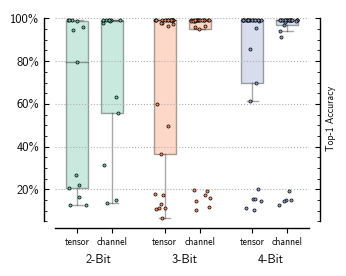

In [144]:

fig = plt.figure(figsize=(3.5, 2.8))
ax = fig.gca()

def plot_bitwidth_accuracy(ax, df):
    data = []
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_position(('outward', 8))
    ax.spines['right'].set_position(('outward', 8))
    ax.spines['left'].set_bounds(0.05,1.0)
    ax.spines['right'].set_bounds(0.05,1.0)


    ax.tick_params(axis='y', which='both', right=True, labelright=False, direction='in', labelsize=9)
    ax.tick_params(axis='x', labelsize=7)
    ax.set_ylabel('Top-1 Accuracy', fontsize=7)
    ax.yaxis.set_label_position('right')

    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
    ax.yaxis.grid(visible=True, ls=':')

    ax2 = ax.twiny()
    ax2.spines['top'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['bottom'].set_position(('outward', 12))
    ax2.tick_params(axis='x', which='both', labelbottom=True, top=False, labeltop=False, labelsize=9)
    ax2.set_xticks(np.arange(3)*0.34+0.17, ["2-Bit", "3-Bit", "4-Bit"])

    for bw in [2,3,4]:
        for resolution in ["per_tensor", "per_channel"]:
            res = df[df.qtype == f"8x{bw}_affine_{resolution}"]
            data.append(res.test_acc_top1)

    pos = np.arange(len(data), dtype=np.float64)
    pos[1::2] -= 0.2
    bpl = ax.boxplot(data, positions=pos, widths=0.5, patch_artist=True, showfliers=False, medianprops={'color': 'black', 'alpha': 0.35}, capprops={'alpha': 0.35}, whiskerprops={'alpha': 0.35}, zorder=0)

    cols = sns.color_palette('Set2', 3)
    for i, (b, d, p) in enumerate(zip(bpl['boxes'], data, pos)):
        b.set_facecolor(cols[i//2])
        b.set(alpha=0.35)
        # x_idx = p * np.ones(len(d)) + 0.1 + np.random.rand(len(d)) * 0.25
        x_idx = p * np.ones(len(d)) + np.random.rand(len(d)) * 0.45 - 0.225
        ax.scatter(x_idx, d, color=cols[i//2], s=5, zorder=1, edgecolors='black', linewidth=0.5)

    ax.set_xticklabels(['tensor', 'channel'] * 3)

lenet = lenet[lenet.gradient_clip == 0.5]
plot_bitwidth_accuracy(ax, lenet)
plt.tight_layout()
plt.savefig('/mnt/c/Users/trommer/Desktop/torchapprox-tcad/figures/plots/quant_accuracy_lenet.pdf', bbox_inches='tight')
plt.show()


In [145]:
set(resnet.qtype)

{'8x4_affine_per_channel', '8x4_affine_per_tensor', nan}

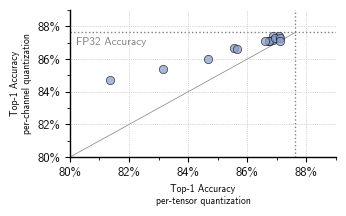

In [146]:
fig = plt.figure(figsize=(3.5, 2.2))
ax = plt.gca()
baseline_acc = resnet[resnet.Name == 'Baseline Model'].test_acc_top1.iloc[0]
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.yaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.xaxis.set_major_locator(ticker.MultipleLocator(0.02))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.01))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
ax.xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1.0, decimals=0))
ax.tick_params(axis='both', which='both', labelsize=9)
ax.set_ylabel('Top-1 Accuracy\nper-channel quantization', fontsize=7)
ax.set_xlabel('Top-1 Accuracy\nper-tensor quantization', fontsize=7)
ax.plot(np.linspace(0,baseline_acc,10), np.linspace(0,baseline_acc,10), zorder=0, color='grey', lw=0.5)
ax.grid(ls=":", lw=0.5)
ax.scatter(resnet[resnet.qtype == '8x4_affine_per_tensor'].test_acc_top1, resnet[resnet.qtype == '8x4_affine_per_channel'].test_acc_top1, color=colors[2], linewidth=0.5, edgecolors='black', zorder=1, alpha=0.75)
ax.hlines(baseline_acc, 0.8, 0.9, ls = ":", color='grey', lw=1.0, zorder=0)
ax.vlines(baseline_acc, 0.8, 0.9, ls = ":", color='grey', lw=1.0, zorder=0)
ax.text(0.802, baseline_acc-0.008, "FP32 Accuracy", color='grey')
ax.set_ylim(0.8, 0.89)
ax.set_xlim(0.8, 0.89)
plt.tight_layout()
plt.savefig('/mnt/c/Users/trommer/Desktop/torchapprox-tcad/figures/plots/quant_accuracy_resnet.pdf', bbox_inches='tight')
plt.show()

In [149]:
pt = ['tensor' in q for q in lenet.qtype]
pc = ['channel' in q for q in lenet.qtype]

In [150]:
np.median(lenet[pc].test_acc_top1.values - lenet[pt].test_acc_top1)

0.0010999441146848365

In [172]:
rt = ['Approximate' in n for n in resnet.Name]
resnet = resnet[rt]

names = []
for m in np.unique(resnet.mul_name):
    if (resnet[resnet.mul_name == m].test_acc_top1 >= 0.8).all():
        names.append(m)
idx = [m in names for m in resnet.mul_name]
resnet = resnet[idx]
pt = [('tensor' in r) and (q >= 0.8) for r,q in zip(resnet['qtype'], resnet['test_acc_top1'])]
pc = [('channel' in r) and (q >= 0.8) for r,q in zip(resnet['qtype'], resnet['test_acc_top1'])]

In [176]:
np.mean(resnet[pt].test_acc_top1.values - resnet[pc].test_acc_top1.values)

-0.008861532578101525

In [170]:
names

['mul8x4u_291',
 'mul8x4u_29A',
 'mul8x4u_29C',
 'mul8x4u_2DB',
 'mul8x4u_2GR',
 'mul8x4u_2L5',
 'mul8x4u_2TZ',
 'mul8x4u_3CY',
 'mul8x4u_3N3',
 'mul8x4u_3NP',
 'mul8x4u_42Z',
 'mul8x4u_49L',
 'mul8x4u_579']

In [160]:
pt

[False, False]